In [36]:
# imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as Holt

from datetime import datetime
from sklearn.metrics import mean_squared_error

# default viz settings
plt.rc('figure', figsize=(10, 8))
plt.rc('font', size=14)
plt.rc('lines', linewidth=2, c='m')
plt.style.use('seaborn-whitegrid')

from acquire import get_opsd_germany, get_df, merge_items_stores_sales
from prepare import prepare_stores_items, prepare_opsd_germany

In [2]:
# acquire the data
items = get_df('items')
stores = get_df('stores')
sales = get_df('sales')
items.head(2)

,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,Caress,2,Caress Velvet Bliss Ultra Silkening Beauty Bar...,6.44,11111065925,11111065925


In [7]:
# merge into one df
df = merge_items_stores_sales(sales, stores, items)
df.head(3)

,sale_amount,sale_date,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013


In [8]:
df = prepare_stores_items(df)
df.head(3).T

sale_date,2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00
sale_amount,13,26,27
sale_id,1,211817,832657
store_address,12125 Alamo Ranch Pkwy,12018 Perrin Beitel Rd,12018 Perrin Beitel Rd
store_city,San Antonio,San Antonio,San Antonio
store_id,1,7,7
store_state,TX,TX,TX
store_zipcode,78253,78217,78217
item_brand,Riceland,Mueller,Mama Marys
item_id,1,12,46
item_name,Riceland American Jazmine Rice,Mueller Sport Care Basic Support Level Medium ...,Pizza Sauce


to include in prep:
* sort by date
* rename sale_amount to items_sold
* resample daily
* remove leap days

In [10]:
df = df.groupby(['sale_date'])[['dollars_sold', 'items_sold']].sum().reset_index().set_index('sale_date')
df.head()

KeyError: "Columns not found: 'dollars_sold', 'items_sold'"

In [11]:
# remove leap days
df = df[df.index != '2016-02-29']

In [12]:
train_size = int(len(df) * .5)
train_size

456250

In [13]:
validate_size = int(len(df) * .3)
validate_size

273750

In [14]:
test_size = int(len(df) - train_size - validate_size)
test_size

182500

In [15]:
validate_end_index = train_size + validate_size
validate_end_index

730000

Now use these values to split

In [16]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

Verify splits

In [17]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [18]:
print(df.head(1) == train.head(1))

                           sale_amount  sale_id  store_address  store_city  \
sale_date                                                                    
2013-01-01 00:00:00+00:00         True     True           True        True   

                           store_id  store_state  store_zipcode  item_brand  \
sale_date                                                                     
2013-01-01 00:00:00+00:00      True         True           True        True   

                           item_id  item_name  item_price  item_upc12  \
sale_date                                                               
2013-01-01 00:00:00+00:00     True       True        True        True   

                           item_upc14  month  weekday  sales_total  
sale_date                                                           
2013-01-01 00:00:00+00:00        True   True     True         True  


In [19]:
pd.concat([train.tail(1), validate.head(1)])

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,month,weekday,sales_total
sale_date,,,,,,,,,,,,,,,,
2015-07-02 00:00:00+00:00,39.0,336897,1520 Austin Hwy,San Antonio,5,TX,78218,Careone,19,Careone Family Comb Set - 8 Ct,0.74,41520035646,41520035646,7,Thursday,28.86
2015-07-02 00:00:00+00:00,56.0,378895,15000 San Pedro Ave,San Antonio,8,TX,78232,Doctors Best,21,Doctors Best Best Curcumin C3 Complex 1000mg T...,8.09,753950001954,753950001954,7,Thursday,453.04


In [20]:
pd.concat([validate.tail(1), test.head(1)])

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,month,weekday,sales_total
sale_date,,,,,,,,,,,,,,,,
2016-12-31 00:00:00+00:00,74.0,589433,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,The First Years,33,Tomy The First Years Gumdrop Orthodontic Pacif...,6.52,71463060078,71463060078,12,Saturday,482.48
2017-01-01 00:00:00+00:00,18.0,481700,516 S Flores St,San Antonio,4,TX,78204,Morton,27,Morton Kosher Salt Coarse,6.01,24600017008,24600017008,1,Sunday,108.18


In [21]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [25]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plot.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [26]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type'}

## Forecast

In [28]:
train.tail()

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,month,weekday,sales_total
sale_date,,,,,,,,,,,,,,,,
2015-07-02 00:00:00+00:00,79.0,318637,1520 Austin Hwy,San Antonio,5,TX,78218,Scotch,18,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,21200725340,21200725340,7,Thursday,346.81
2015-07-02 00:00:00+00:00,80.0,517671,516 S Flores St,San Antonio,4,TX,78204,Heinz,29,Heinz Tomato Ketchup - 2 Ct,8.65,13000001038,13000001038,7,Thursday,692.00
2015-07-02 00:00:00+00:00,119.0,141515,15000 San Pedro Ave,San Antonio,8,TX,78232,Lea & Perrins,8,Lea & Perrins Marinade In-a-bag Cracked Pepper...,1.68,51600080015,51600080015,7,Thursday,199.92
2015-07-02 00:00:00+00:00,69.0,563321,735 SW Military Dr,San Antonio,9,TX,78221,Zhenas Gypsy Tea,31,Zhenas Gypsy Tea Herbal Red Tea Sachets Fire L...,4.21,652790100226,652790100226,7,Thursday,290.49
2015-07-02 00:00:00+00:00,39.0,336897,1520 Austin Hwy,San Antonio,5,TX,78218,Careone,19,Careone Family Comb Set - 8 Ct,0.74,41520035646,41520035646,7,Thursday,28.86


In [30]:
#dollars prediction
dollars = round(train['dollars_sold'][-1:][0], 2)
dollars

In [ ]:
#items prediction
items = train['items_sold'][-1][0]
items

In [ ]:
# create dataframe of predictions
yhat_df = pd.DataFrame({'dollars_sold': [dollars], 'items_sold': [items]}), index = validate.index)

yhat_df.head()

In [ ]:
plot_and_eval('dollars_sold')

In [ ]:
for col in train.columns:
    plot_and_eval(col)

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed')

## Simple Average - the Baseline

In [ ]:
# compute simple average
plt. plot(train['dollars_sold'])

In [ ]:
dollars = round(train['items_sold'].mean(), 2)
dollars

In [ ]:
items = round(train['items_sold'].mean(), 2)
items

In [ ]:
def make_predictions():
    yhat_df = pd.DataFrame({'dollars_sold': [dollars],
                           'items_sold': [items]},
                          index = validate.index)
    return yhat_df

In [ ]:
yhat_df = make_predictions()

In [ ]:
yhat_df.describe()

In [ ]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average',
                             target_var = col)
eval_df

In [32]:
# train['dollars_sold'].tail(30)
# better to use the rolling function
plt.plot(train['dollars_sold'].rolling(30).mean())

In [33]:
# higher rolling number causes exponential smooting and a little more lag

In [37]:
period = 30

dollars = round(train['dollars_sold'].rolling(period).mean()[-1], 2)
items = round(train['items_sold'].rolling(period).mean()[-1], 2)


KeyError: 'dollars_sold'

NameError: name 'yhat_df' is not defined

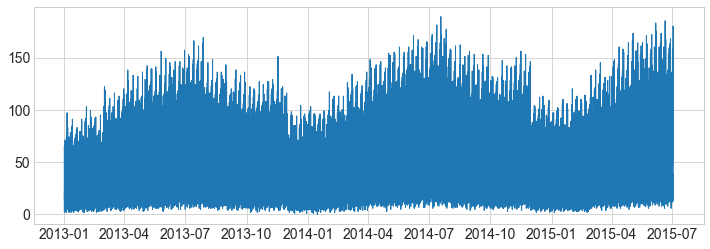

In [38]:
for col in train.columns:
    plot_and_eval(col)

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg',
                            target_var = col)
    
eval_df

In [ ]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    dollars = round(train['dollars_sold'].rolling(p).mean()[-1], 2)
    items = round(train['items_sold'].rolling(p).mean()[-1, 2])
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [ ]:
eval_df.sort_values(ascending = True).head(1)

In [ ]:
min_items_rmse = eval_df[eval_df.target_var == 'items_sold']['rmse'].min()
eval_df[eval_df.rmse == min_items_rmse]